## Inference for the Armond model via particle MCMC 

## Fitting models of metaphase kinetochore oscillations to synthetic data

The model used is the model from [Armond et al. (2015, PloS Comp. Biol.)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004607). This is an SDE dependent on hidden states. 
The key equation for this model is as follows, obtained from discretizing the SDE: 

\begin{align}
(X_{t+\Delta t}^1 - X_t^1)/\Delta t = -v_{\sigma_t^1} -\kappa \left( X_t^1 - X_t^2 -L\cos \theta_t  \right) - \alpha X_t^1 + N(0,s^2), \\
(X_{t+\Delta t}^2 - X_t^2)/\Delta t = +v_{\sigma_t^2} -\kappa \left( X_t^2 - X_t^1 +L\cos \theta_t  \right) - \alpha X_t^2 + N(0,s^2),
\end{align}
where $\sigma_1$ and $\sigma_2$ are hidden states taking values in the set $$(\sigma_1, \sigma_2) \in \{ (+,+),(+,-),(-,+),(-,-) \}$$
with switching rates $p_{coh}$ and $p_{icoh}$ between states based on whether $\sigma_1$ and $\sigma$ are the same (incoherent) or not (coherent). 

To fit this model, we use SMC2 which uses a particle filter both for the discrete hidden states and in parameter space nested together. This an alternative to using a traditional Metropolis-Hastings type kernel to explore parameter space with accept-reject decisions based on a particle filter as in particle marginal Metropolis Hastings (PMMH) methods. One of the motivations for SMC2 in this context is that it should require less tuning than the PMMH methods. These methods are implemented via [Libbi](http://libbi.org/), which can make use of the parallel computing architectures on modern machines. 


We can load the library and set things up as follows

In [47]:
using SMC, Random, Distributions, DataFrames
trueValues = [450, 0.008, 0.025, -0.035, 0.015, 0.9, 0.95, 0.775]
thetaDF = DataFrame(paramNames = ["tau","alpha","kappa","v_minus","v_plus","p_icoh","p_coh","L"],
                    trueValues = trueValues)
th = thetaSimple(trueValues[1], trueValues[2], trueValues[3], trueValues[4],
    trueValues[5], trueValues[6], trueValues[7], trueValues[8], 2.0)
(armondhmmSimple, transll, approxtrans, approxll) = armondModelSimple(th)
hmm = HMM(armondhmmSimple, transll)
x0 = [0, 1, 0, 0];
y0 = [0.9, 0];

We generate synthetic data from the model and plot to check that this looks as it should.
We can then use this synthetic data to infer known model parameters.

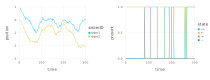

In [48]:
### generation from armond model
Random.seed!(123)
K=150
(states, observations) = generate(armondhmmSimple, x0, y0, K);

### preparation for plotting
using Gadfly, DataFrames
set_default_plot_size(21cm, 8cm)
dfObs = DataFrame(transpose(observations));
dfStates = DataFrame(transpose(states));
names!(dfObs, [Symbol("sister$i") for i in 1:2]) #change columns names, see https://stackoverflow.com/questions/21559683/how-do-you-change-multiple-column-names-in-a-julia-version-0-3-dataframe
names!(dfStates, [Symbol("++"), Symbol("+-"), Symbol("-+"), Symbol("--")])
dfT = DataFrame(time = th.dt*collect(1:K));
df = [dfT dfObs dfStates]
df = stack(df,[:sister1, :sister2], variable_name=Symbol("sisterID"),value_name=Symbol("position")) #reshape from wide to long
df = stack(df, 4:7, variable_name=Symbol("state"), value_name=Symbol("present"))
p1 = plot(df, x="time",y = "position", color="sisterID", Geom.line)
p2 = plot(df, x="time",y = "present", color="state", Geom.line)
hstack(p1,p2)

In [3]:
#prepare for parallel processing
using Distributed
addprocs(8)
module_dir = "/Users/jonathanharrison/.julia/dev/SMC.jl"
@everywhere push!(LOAD_PATH, $module_dir) #see https://discourse.julialang.org/t/loading-modules-on-remote-workers-in-julia-1-0-7/13312/3
@everywhere using Distributions, SMC, Random


In [44]:
#Optimize the number of particles to use in the particle filter
using DataFrames
using Statistics: var
Random.seed!(123) #not sure this seeds properly on all processes
function getOptimumNumParticles(; NVec = 2 .^(3:10), th_star::Array = [0.9, 0.95],
                                nRepeats::Int=100, filter::String="Aux", u=nothing)
    llVar = zeros(length(NVec))
    i = 1
    @time llVar[i] =  var(pmap(x -> runFilter(th_star, u, observations; N=NVec[i], filterMethod=filter), 1:nRepeats))
    while llVar[i] > 3
        i+=1
        if i>length(NVec)
            println("Unable to find optimum N")
            break
        end
        @time llVar[i] =  var(pmap(x -> runFilter(th_star, u, observations; N=NVec[i], filterMethod=filter), 1:nRepeats))
    end
    println("Optimum is N=", NVec[i], " with a variance of ", llVar[i])
    return DataFrame(N=NVec[1:i], Variance=llVar[1:i], Method = repeat([filter],i))
end
filterMethods = ["Aux","Boot"]
out = map(x -> getOptimumNumParticles(th_star = thetaDF[:trueValues],
        filter=x), filterMethods)
Ndf = [out[1]; out[2]]
Gadfly.plot(Ndf, x="N",y="Variance",color="Method", Geom.line)

UndefVarError: UndefVarError: pmap not defined

Now we can specify parameter proposal distributions and run multiple chains of the particle MCMC. Use pilot run to estimate the variance to use for proposal distribution. 

In [49]:
Random.seed!(125)
dimParams = 2
proposalWidthLU = [50 0 Inf;
                   0.01 0 Inf;
                   0.01 0 Inf;    
                   0.02 -Inf 0;     
                   0.02 0 Inf;           
                   0.05 0 1;
                   0.05 0 1;
                   0.05  0 Inf] #std, lower and upper for truncated normal proposal
paramProposal = [x -> TruncatedNormal(x,proposalWidthLU[i,1],proposalWidthLU[i,2],proposalWidthLU[i,3]) for i in 1:dimParams]
priors = [Gamma(1/0.5,1/0.001), #tau: shape vs rate paramterisation
    TruncatedNormal(0.01,sqrt(10000),0,Inf), #alpha
    TruncatedNormal(0.05,sqrt(10000),0,Inf), #kappa
    TruncatedNormal(-0.03,sqrt(10),-Inf,0), #v_minus
    TruncatedNormal(0.03, sqrt(10),0,Inf), #v_plus
    Beta(2,1), #p_icoh
    Beta(2.5,1), #p_coh
    TruncatedNormal(0.775,sqrt(0.0121),0,Inf) #L
]
initialisationFn = [TruncatedNormal(450,100,0,Inf), #tau: shape vs rate paramterisation
    TruncatedNormal(0.01,0.01,0,Inf), #alpha
    TruncatedNormal(0.025,0.01,0,Inf), #kappa
    TruncatedNormal(-0.03,0.02,-Inf,0), #v_minus
    TruncatedNormal(0.03,0.02,0,Inf), #v_plus
    TruncatedNormal(0.9,0.1,0,1), #p_icoh
    TruncatedNormal(0.95,0.1,0,1), #p_coh
    TruncatedNormal(0.775,0.1,0,Inf) #L
]
if dimParams==2
    #use simpler model with only p_coh and p_icoh
    proposalWidthLU = proposalWidthLU[6:7,:]
    priors = priors[6:7]
    initialisationFn = initialisationFn[6:7]
end
numIter = 200
nChains = 6
N = 64;
numRandoms = K*(N+1);


In [50]:
#pilot run to estimate variance
using MCMCChains
numIterPilot = 100
thin = 1
nThinned = Int(numIterPilot/thin)

@time (cPilot,actRatePilot) = correlated(observations, priors,
         paramProposal, dimParams, numRandoms, numIter=numIterPilot,
         printFreq=100, initialisationFn=initialisationFn, N=N);

#with better variance estimation
chn=Chains(reshape(cPilot[1:thin:end,:],nThinned,dimParams,1), start=1, thin=thin)
minESS = minimum(ess(chn)[:,:ess])
mu = sum(cPilot[1:thin:end,:],dims=1)/nThinned
varPilot = sum((cPilot[1:thin:end,:] .- repeat(mu,nThinned)).^2,dims=1)/minESS
println(varPilot)
scalingFactor = 2.56/dimParams #see Golightly et al 2017
#set optimized Proposal
paramProposalOptim = [x -> TruncatedNormal(x,sqrt(varPilot[i])*scalingFactor,proposalWidthLU[i,2],proposalWidthLU[i,3]) for i in 1:dimParams];

Iter: 100
acceptance rate is: 0.24
 17.672949 seconds (231.99 M allocations: 12.862 GiB, 28.80% gc time)
[0.340305 0.0518514]


In [6]:
numIterPilot = 100
varPilot = [sqrt(0.34),sqrt(0.05)]
scalingFactor = 2.56/dimParams #see Golightly et al 2017
paramProposalOptim = [x -> TruncatedNormal(x,sqrt(varPilot[i])*scalingFactor,proposalWidthLU[i,2],proposalWidthLU[i,3]) for i in 1:dimParams];

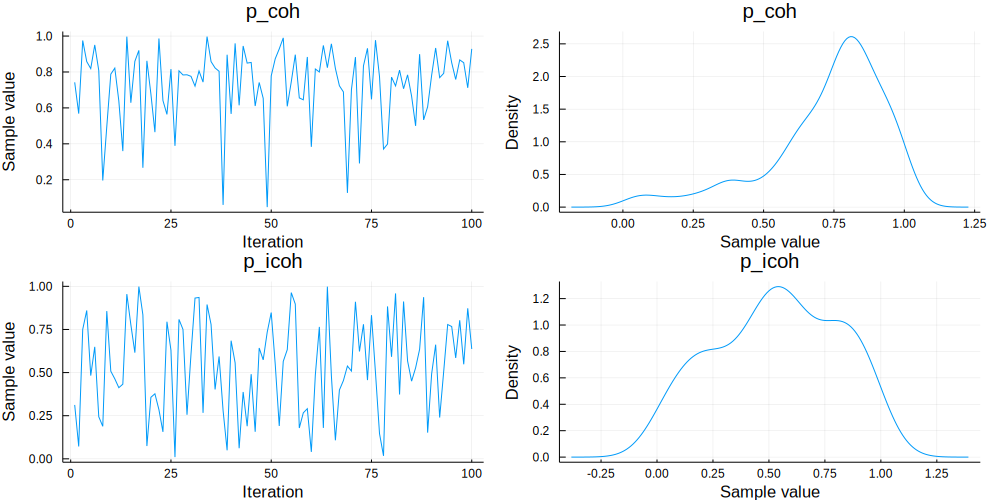

In [51]:
#use this to check proposal distribution 
using MCMCChains, StatsPlots
if dimParams == 8
    th_init = [450,0.01,0.025,-0.03,0.03,0.9,0.95,0.8]
    paramNames = ["tau","alpha","kappa","v_minus","v_plus","p_icoh","p_coh","L"]
elseif dimParams == 2
    th_init = [0.9,0.95]
    paramNames = ["p_icoh","p_coh"]
else
    error("wrong number of parameters specified")
end
priorSamples = zeros(numIterPilot,dimParams,1)
for i=1:dimParams 
    priorSamples[:,i,1] = rand(paramProposalOptim[i](th_init[i]),numIterPilot)
end
prChn = Chains(priorSamples,paramNames)
# visualize the MCMC simulation results
p1 = StatsPlots.plot(prChn, colordim = :parameter)
p2 = StatsPlots.plot(prChn)

In [8]:
@time out = pmap(x -> correlated(observations, priors,
         paramProposalOptim, dimParams, numRandoms,
         numIter=numIter, printFreq=1000, initialisationFn=initialisationFn,
         N=N, rho=0.99), 1:nChains);


 73.855230 seconds (4.08 M allocations: 199.846 MiB, 0.36% gc time)


In [28]:
tV = trueValues
theta = thetaSimple(trueValues[1], trueValues[2], trueValues[3], trueValues[4],
    trueValues[5], trueValues[6], trueValues[7], trueValues[8], 2.0)
@time for i=1:1000 M1 = [(-theta.kappa - theta.alpha) theta.kappa -theta.v_plus -theta.v_plus -theta.v_minus -theta.v_minus;
            theta.kappa (-theta.kappa - theta.alpha) theta.v_plus theta.v_minus theta.v_plus theta.v_minus]; end
@time for i=1:1000 M2 = [(-tV[3]-tV[2]) tV[3] -tV[5] -tV[5] -tV[4] -tV[4];
        tV[3] (-tV[3]-tV[2]) tV[5] tV[4] tV[5] tV[4]]; end

  0.000119 seconds (2.30 k allocations: 51.563 KiB)
  0.000086 seconds (2.30 k allocations: 51.563 KiB)


In [53]:
 using Profile
Profile.clear()
@time @profile correlated(observations, priors,
         paramProposalOptim, dimParams, numRandoms,
         numIter=numIter, printFreq=10, initialisationFn=initialisationFn,
         N=N, rho=0.99);

Iter: 10
acceptance rate is: 0.0
Iter: 20
acceptance rate is: 0.0
Iter: 30
acceptance rate is: 0.0
Iter: 40
acceptance rate is: 0.0
Iter: 50
acceptance rate is: 0.02
Iter: 60
acceptance rate is: 0.05
Iter: 70
acceptance rate is: 0.04285714285714286
Iter: 80
acceptance rate is: 0.0375
Iter: 90
acceptance rate is: 0.03333333333333333
Iter: 100
acceptance rate is: 0.03
Iter: 110
acceptance rate is: 0.02727272727272727
Iter: 120
acceptance rate is: 0.025
Iter: 130
acceptance rate is: 0.023076923076923078
Iter: 140
acceptance rate is: 0.02142857142857143
Iter: 150
acceptance rate is: 0.02
Iter: 160
acceptance rate is: 0.01875
Iter: 170
acceptance rate is: 0.01764705882352941
Iter: 180
acceptance rate is: 0.016666666666666666
Iter: 190
acceptance rate is: 0.021052631578947368
Iter: 200
acceptance rate is: 0.02
 46.144608 seconds (462.47 M allocations: 25.649 GiB, 28.93% gc time)


In [54]:
Profile.print(format=:flat)

┌ Warning: The profile data buffer is full; profiling probably terminated
│ before your program finished. To profile for longer runs, call
│ `Profile.init()` with a larger buffer and/or larger delay.
└ @ Profile /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Profile/src/Profile.jl:312


 Count File                        Line Function                               
    49 ./abstractarray.jl          1511 #cat#104                               
    49 ./abstractarray.jl          1384 #cat_t#103                             
     1 ./abstractarray.jl          1398 __cat(::Array{Float64,1}, ::Tuple{In...
    10 ./abstractarray.jl          1402 __cat(::Array{Float64,1}, ::Tuple{In...
     3 ./abstractarray.jl          1403 __cat(::Array{Float64,1}, ::Tuple{In...
    15 ./abstractarray.jl          1408 __cat(::Array{Float64,1}, ::Tuple{In...
    11 ./abstractarray.jl          1409 __cat(::Array{Float64,1}, ::Tuple{In...
     3 ./abstractarray.jl          1410 __cat(::Array{Float64,1}, ::Tuple{In...
    49 ./abstractarray.jl          1382 _cat                                   
     6 ./abstractarray.jl          1388 _cat_t                                 
    43 ./abstractarray.jl          1392 _cat_t                                 
   119 ./abstractarray.jl            75 

┌ Warning: The profile data buffer is full; profiling probably terminated
│ before your program finished. To profile for longer runs, call
│ `Profile.init()` with a larger buffer and/or larger delay.
└ @ Profile /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Profile/src/Profile.jl:312


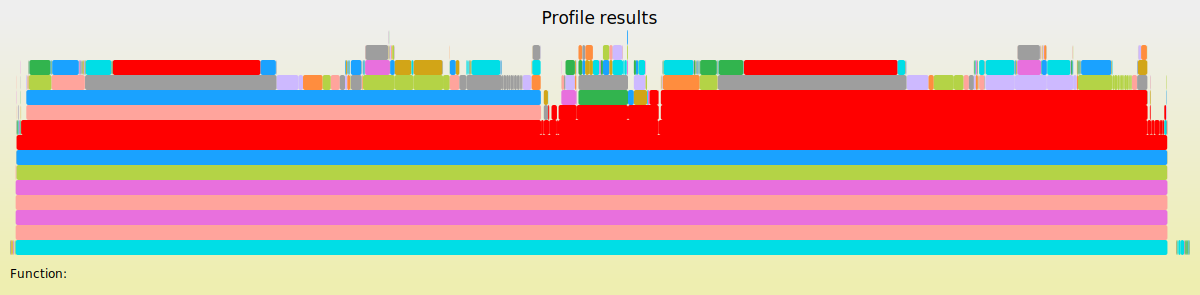

In [55]:
using ProfileView
ProfileView.view()

In [ ]:
#extracting from output of pmap is a bit messy; https://stackoverflow.com/questions/44234255/return-multiple-values-from-a-mapped-function
cTemp, actRate = map(x->getindex.(out, x), 1:2)
c =  zeros(numIter,dimParams,nChains)
for i=1:nChains
    c[:,:,i] = cTemp[i]
end

We can plot the chains and assess convergence. 


In [ ]:
using MCMCChains, StatsPlots
theme(:ggplot2)
thetaDFCopy = (dimParams==8) ? thetaDF : (dimParams==2) ? thetaDF[6:7,:] : nothing 
thin = 1
chn=Chains(c[1:thin:end,:,:], thetaDFCopy[:paramNames], start=1, thin=thin);
Rhat = gelmandiag(chn)
println(Rhat)

# visualize the MCMC simulation results
p1 = StatsPlots.plot(chn, colordim = :parameter);
p2 = StatsPlots.plot(chn, width=3, layout = [8,2]);
th_true = 0
for i=1:dimParams
    for j=1:dimParams
        if string(Rhat[:parameters][i]) == thetaDFCopy[:paramNames][j]
            th_true = thetaDFCopy[:trueValues][j]
            break
        end
    end
    StatsPlots.plot!(p2[i,1],1:numIter, repeat([th_true],numIter),color="black",linestyle=:dash)
#    StatsPlots.plot!(p2[i,2],repeat([th_true],100), range(0,stop=10/th_true,length=100),color="black")
end
p2